In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [15]:
import pandas as pd

# Load the dataset
columns = [
    'Family Name', 
    'Variation',
    'Algorithm Name', 
    'Year', 
    'Time Complexity Class',
    'Approximation Factor Class (Mult)', 
    'Approximation Factor Class (Add)',
    'Approximation Type (additive/multiplicative)',	
    'Parametrized Approximation?',
    'Type of PTAS (if PTAS)'
]
approximated_algorithms = pd.read_csv('approximated_algorithms.csv', usecols=columns)

# Clean and prepare the data


approximated_algorithms['Year'] = pd.to_numeric(approximated_algorithms['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
approximated_algorithms.dropna(subset=['Year'], inplace=True)
approximated_algorithms['Year'] = approximated_algorithms['Year'].astype(int)

for col in ['Time Complexity Class', 'Approximation Factor Class (Mult)', 'Approximation Factor Class (Add)']:
    approximated_algorithms[col] = pd.to_numeric(approximated_algorithms[col].astype(str).str.extract(r'(\d+)')[0], errors='coerce').fillna(99999)
    approximated_algorithms[col] = approximated_algorithms[col].replace(0, 99999)

# Sort the DataFrame for correct group-wise comparison
approximated_algorithms.sort_values(by=['Family Name', 'Variation', 'Year'], inplace=True)

approximated_algorithms['Improvement'] = 0
# Identify improvements
def identify_improvements(group):
    # Ensure necessary columns are present
    necessary_columns = ['Time Complexity Class', 'Approximation Factor Class (Mult)', 'Approximation Factor Class (Add)']
    if not all(col in group.columns for col in necessary_columns):
        raise ValueError("Missing one or more necessary columns")

    # Initialize 'Improvement' column and 'Best_' columns safely
    group['Improvement'] = 0
    for col in necessary_columns:
        group['Best_' + col] = 999999

    # Initialize best values for the first row
    for col in necessary_columns:
        group['Best_' + col].iat[0] = group[col].iat[0]
        group['Improvement'].iat[0] = 0

    # Compute best values and track improvements
    for i in range(1, len(group)):
        for col in necessary_columns:
            previous_best = group['Best_' + col].iat[i - 1]
            current_value = group[col].iat[i]

            if current_value < previous_best:
                group['Best_' + col].iat[i] = current_value
                group['Improvement'].iat[i] = 1
            else:
                group['Best_' + col].iat[i] = previous_best

    # Drop helper columns
    drop_cols = ['Best_' + col for col in necessary_columns]
    group.drop(columns=drop_cols, inplace=True)

    return group


approximated_algorithms = approximated_algorithms.groupby(['Family Name', 'Variation']).apply(identify_improvements)

approximated_algorithms['Improvement'] = approximated_algorithms['Improvement'].astype(int)

approximated_algorithms


/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_45932/3905864033.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  approximated_algorithms = approximated_algorithms.groupby(['Family Name', 'Variation']).apply(identify_improvements)


Family Name  \
Family Name                     Variation                                                                                 
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 148  All-Pairs Shortest Paths (APSP)   
                                                                                   149  All-Pairs Shortest Paths (APSP)   
                                                                                   150  All-Pairs Shortest Paths (APSP)   
                                                                                   151  All-Pairs Shortest Paths (APSP)   
                                                                                   152  All-Pairs Shortest Paths (APSP)   
...                                                                                                                 ...   
kth Order Statistic             Approximate kth Order Statistic                    7                kth Order Statistic   
                                                                                   8                kth Order Statistic   
                                                                                   9                kth Order Statistic   
                                                                                   10               kth Order Statistic   
n-Queens Problem                n-Queens Completion                                864                 n-Queens Problem   

                                                                                                                                Variation  \
Family Name                     Variation                                                                                                   
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 148  APSP, unweighted, undirected, no FMM (Approxim...   
                                                                                   149  APSP, unweighted, undirected, no FMM (Approxim...   
                                                                                   150  APSP, unweighted, undirected, no FMM (Approxim...   
                                                                                   151  APSP, unweighted, undirected, no FMM (Approxim...   
                                                                                   152  APSP, unweighted, undirected, no FMM (Approxim...   
...                                                                                                                                   ...   
kth Order Statistic             Approximate kth Order Statistic                    7                      Approximate kth Order Statistic   
                                                                                   8                      Approximate kth Order Statistic   
                                                                                   9                      Approximate kth Order Statistic   
                                                                                   10                     Approximate kth Order Statistic   
n-Queens Problem                n-Queens Completion                                864                                n-Queens Completion   

                                                                                                                     Algorithm Name  \
Family Name                     Variation                                                                                             
All-Pairs Shortest Paths (APSP) APSP, unweighted, undirected, no FMM (Approximate) 148           Aingworth, Chekuri, Indyk, Motwani   
                                                                                   149               Dor, Halperin, Zwick [APASP_2]   
                                                                                   150               Dor, Halperin, Zwick [APASP_k]   

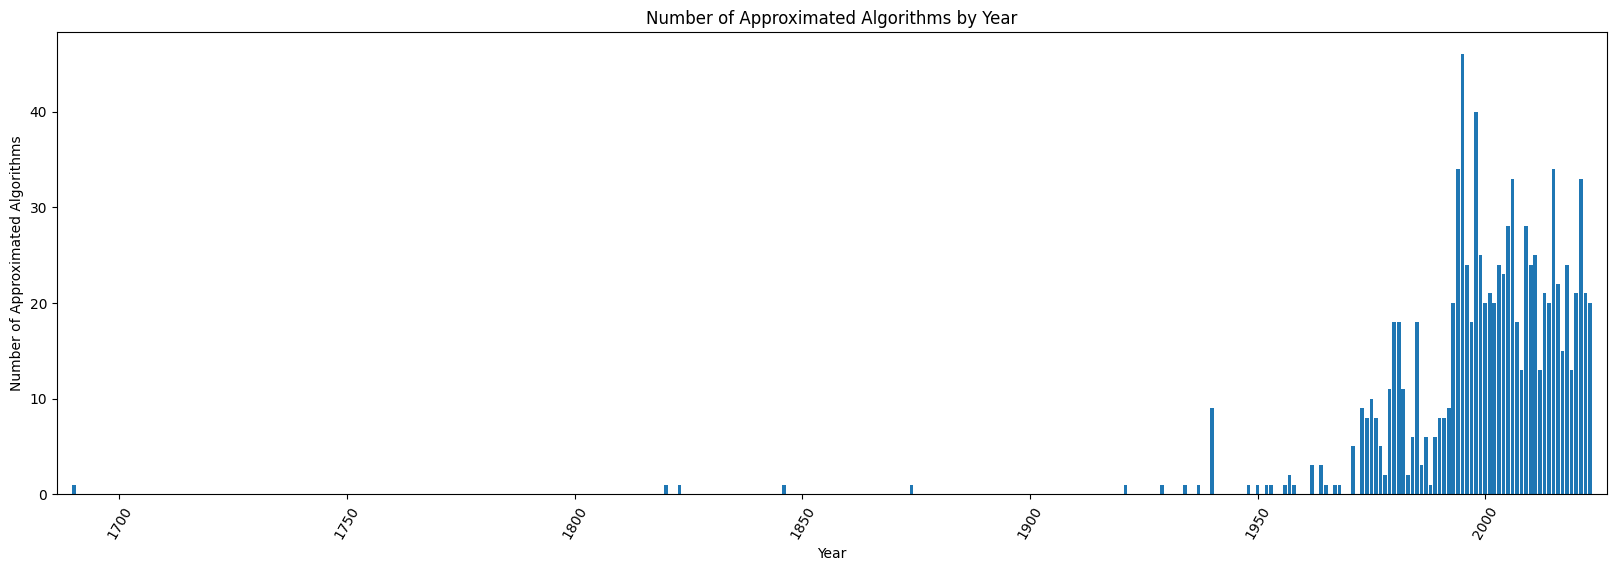

In [16]:
# Plot number of approximated algorithms by year
data = approximated_algorithms

data = data.groupby(['Year']).size()

fig, ax = plt.subplots()
bar_container = ax.bar(data.index, data.values)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximated Algorithms')
ax.set_title('Number of Approximated Algorithms by Year')
plt.show()

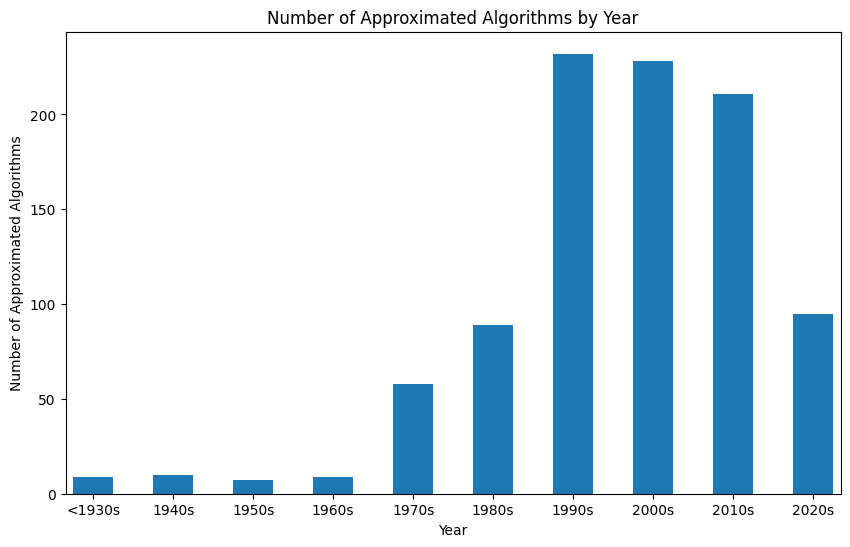

In [17]:
# Plot number of approximated algorithms by decade
data = approximated_algorithms

data = data.groupby(data['Year'] // 10 * 10).size()

# merge all year <= 1930 into 1930
data[1930] = data.loc[:1930].sum()
data = data.drop(data.loc[:1929].index)







fig, ax = plt.subplots()

bar_container = ax.bar(data.index, data.values, width=5)

# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)



ax.set_xticks(data.index)
ax.set_xticklabels(['<1930s'] + [str(year) + 's' for year in data.index[1:]])

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximated Algorithms')
ax.set_title('Number of Approximated Algorithms by Year')
plt.show()

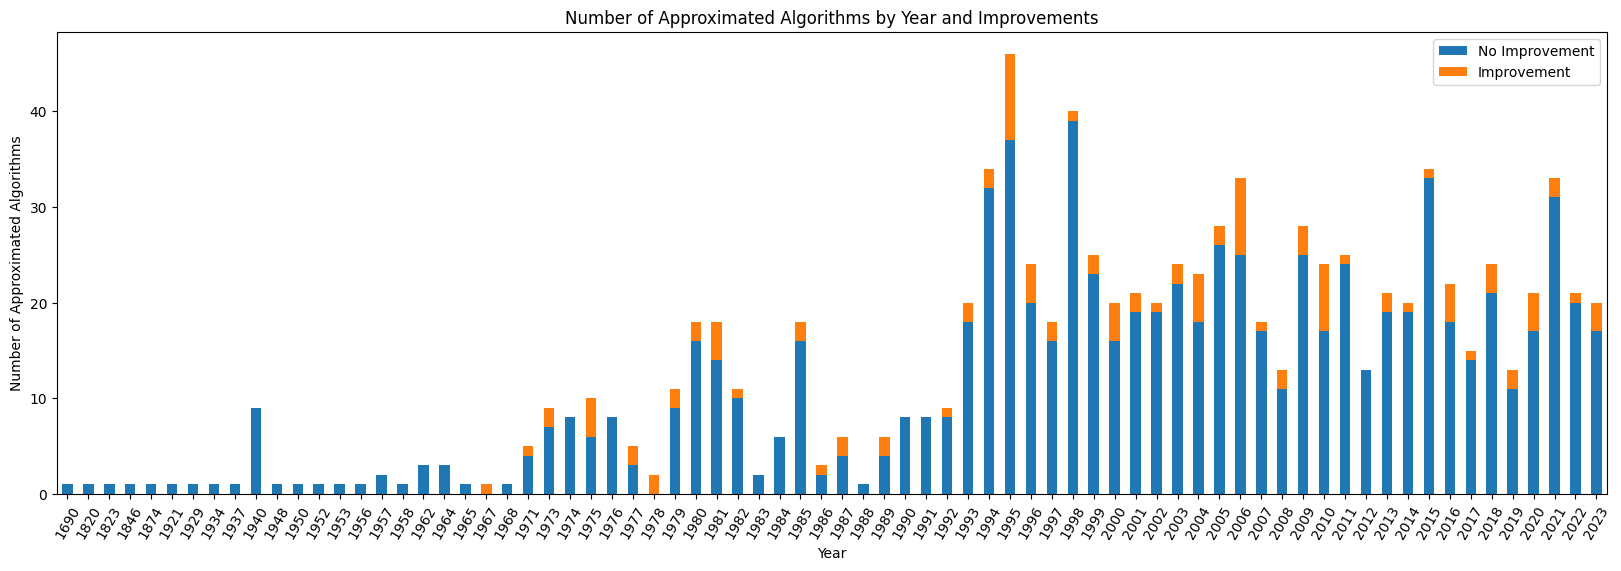

In [18]:
# Plot number of approximated algorithms by year and improvements
data = approximated_algorithms

data = data.groupby(['Year', 'Improvement']).size().unstack().fillna(0)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximated Algorithms')
ax.set_title('Number of Approximated Algorithms by Year and Improvements')

# legent for the plot
plt.legend(['No Improvement', 'Improvement'])

plt.show()






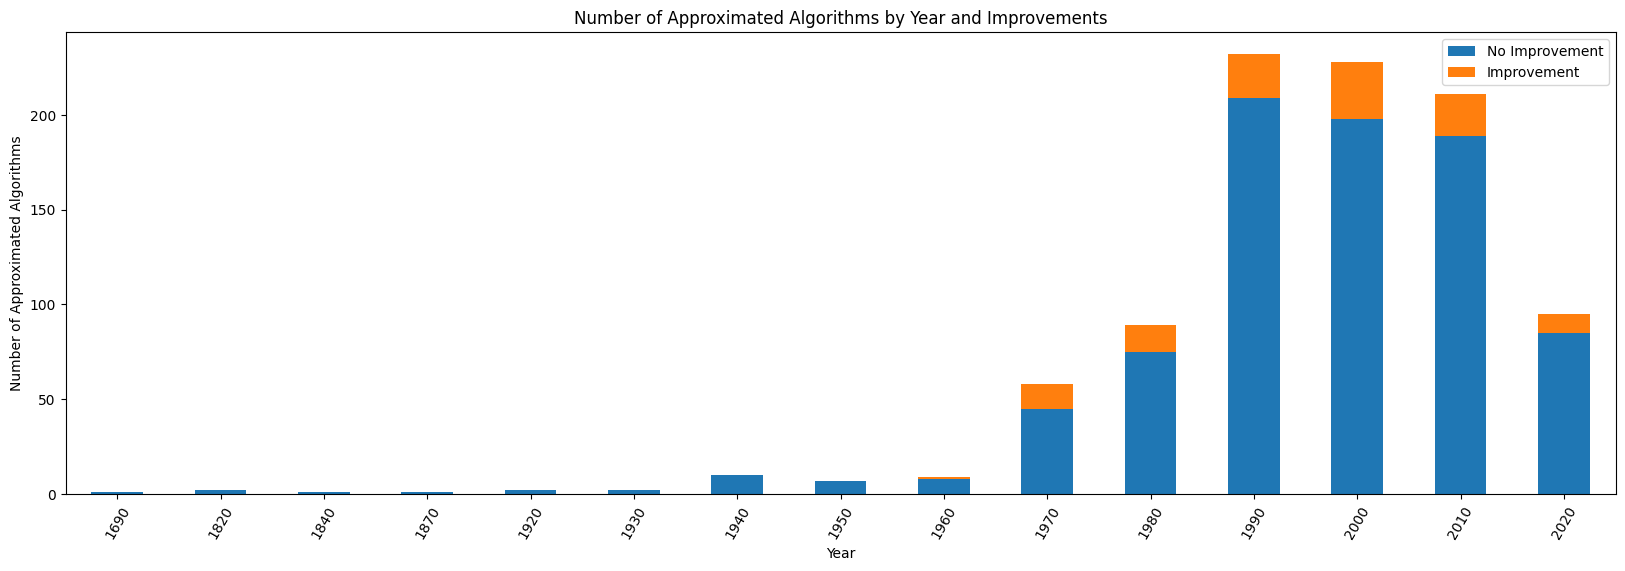

In [19]:
# Plot number of approximated algorithms by decade and improvements
data = approximated_algorithms

data = data.groupby([data['Year'] // 10 * 10, 'Improvement']).size().unstack().fillna(0)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Approximated Algorithms')
ax.set_title('Number of Approximated Algorithms by Year and Improvements')

# legent for the plot
plt.legend(['No Improvement', 'Improvement'])

plt.show()






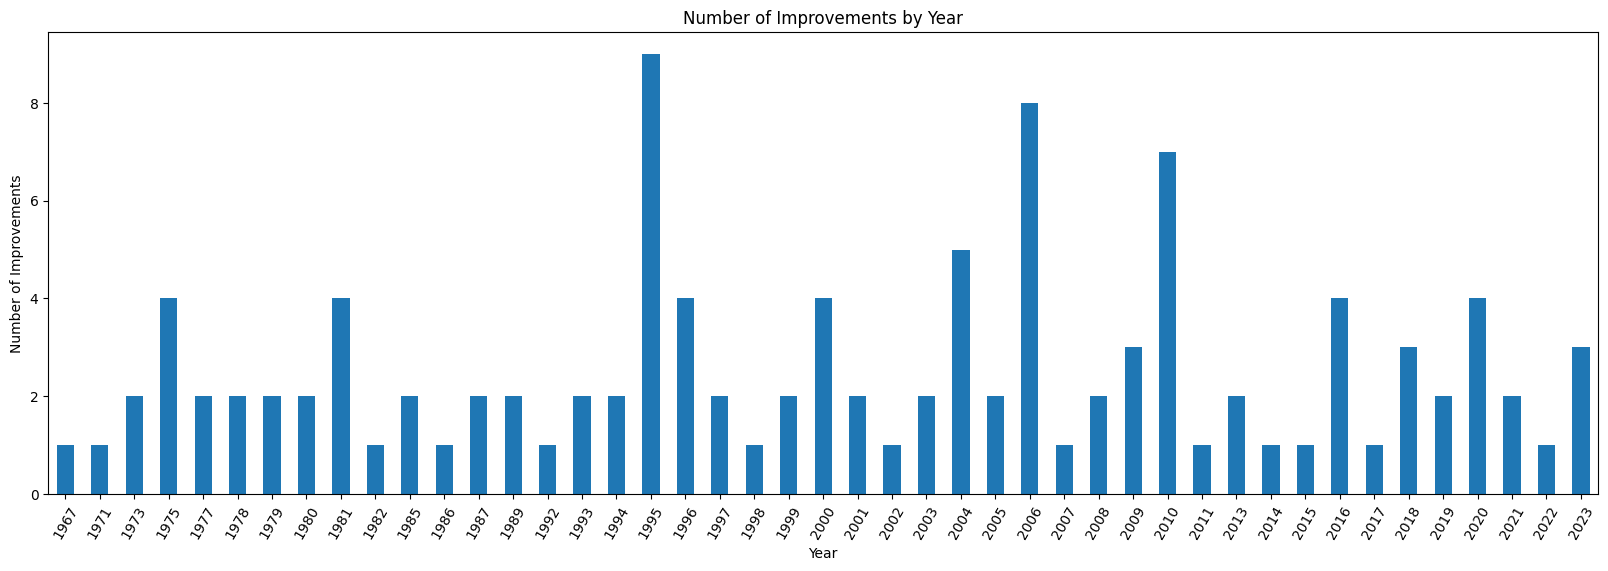

In [20]:
# Plot number of improvements by year
data = approximated_algorithms


        
# plot only  improvements by year

data = data[data['Improvement'] == 1]

data = data.groupby(['Year']).size()





fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Year')
plt.show()


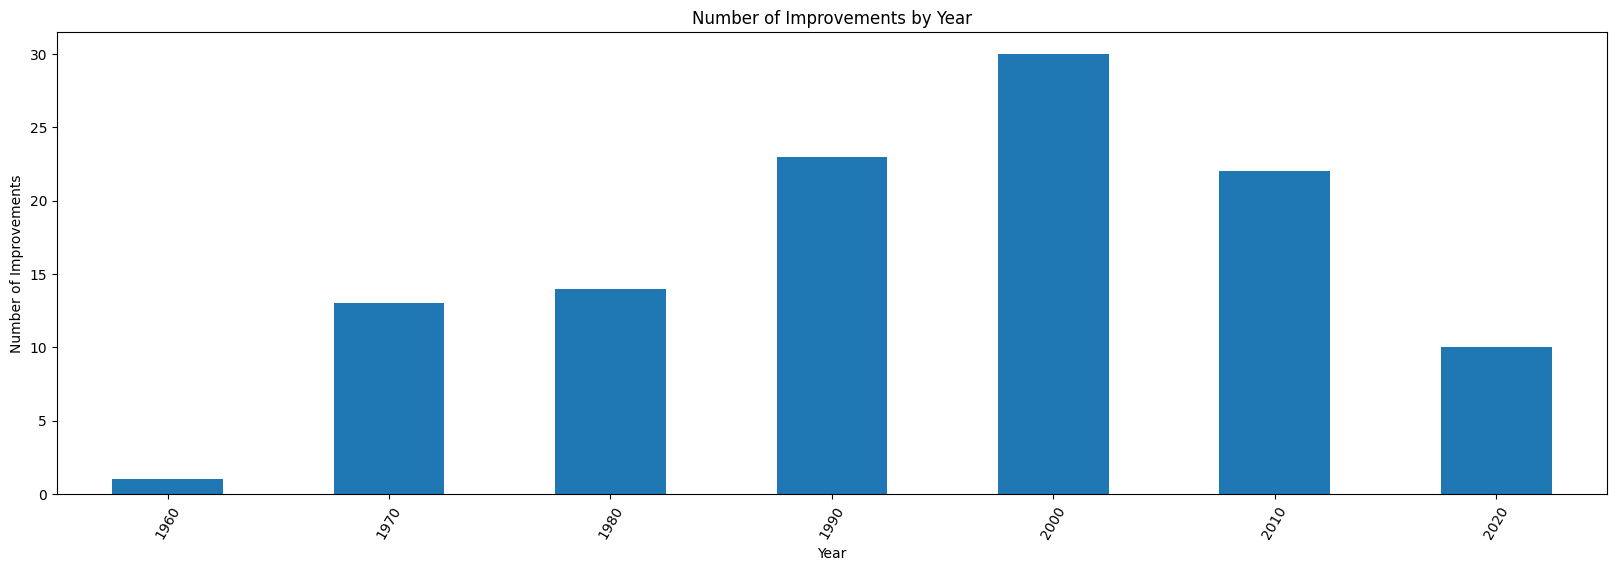

In [21]:
# Plot number of improvements by decade
data = approximated_algorithms


        
# plot only  improvements by year

data = data[data['Improvement'] == 1]

data = data.groupby(data['Year'] // 10 * 10).size()





fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=60)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Improvements')
ax.set_title('Number of Improvements by Year')
plt.show()


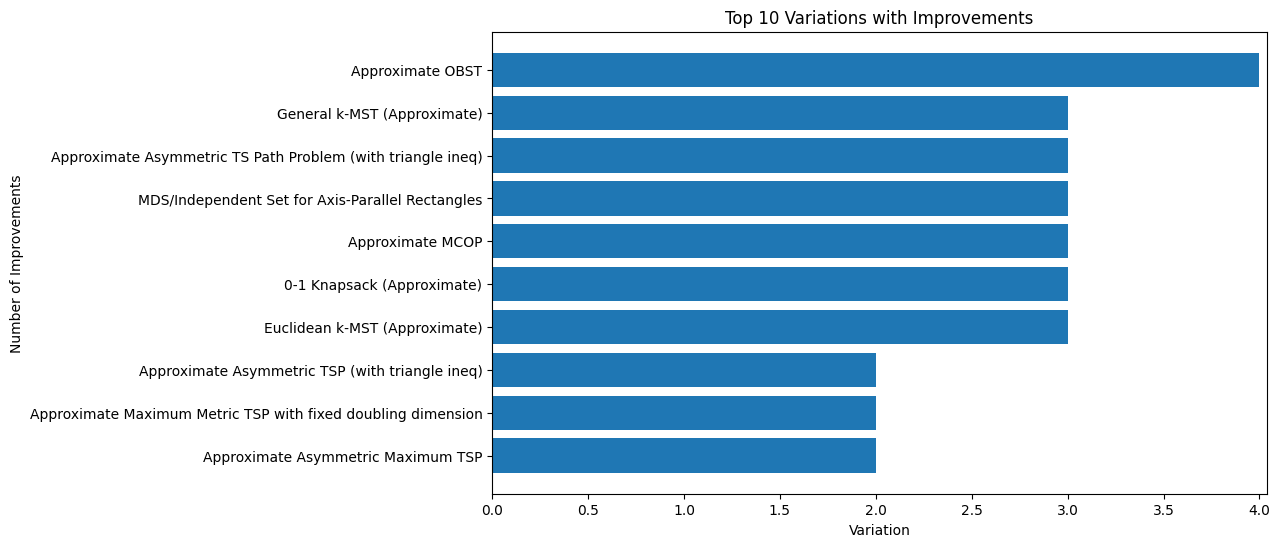

In [22]:
# Plot number of improvements by variation
data = approximated_algorithms

# variation with more improvements
data = data[data['Improvement'] == 1]

# number of improvements by variation
data = data['Variation'].value_counts()

# top 10
data = data.head(10)

fig, ax = plt.subplots()
bar_container = ax.barh(data.index, data.values)

# reverse the order of the y-axis
ax.invert_yaxis()
# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)

ax.set_xlabel('Variation')

ax.set_ylabel('Number of Improvements')

ax.set_title('Top 10 Variations with Improvements')

plt.show()



In [23]:
data = approximated_algorithms
# filter for Maximum Flow
data = data[data['Variation'] == 'Approximate Maximum Flow']
data

Family Name  \
Family Name  Variation                                   
Maximum Flow Approximate Maximum Flow 32  Maximum Flow   
                                      19  Maximum Flow   
                                      18  Maximum Flow   
                                      20  Maximum Flow   
                                      21  Maximum Flow   
                                      22  Maximum Flow   
                                      23  Maximum Flow   
                                      24  Maximum Flow   
                                      25  Maximum Flow   
                                      26  Maximum Flow   
                                      27  Maximum Flow   
                                      28  Maximum Flow   
                                      34  Maximum Flow   

                                                         Variation  \
Family Name  Variation                                               
Maximum Flow Approximate Maximum Flow 32  Approximate Maximum Flow   
                                      19  Approximate Maximum Flow   
                                      18  Approximate Maximum Flow   
                                      20  Approximate Maximum Flow   
                                      21  Approximate Maximum Flow   
                                      22  Approximate Maximum Flow   
                                      23  Approximate Maximum Flow   
                                      24  Approximate Maximum Flow   
                                      25  Approximate Maximum Flow   
                                      26  Approximate Maximum Flow   
                                      27  Approximate Maximum Flow   
                                      28  Approximate Maximum Flow   
                                      34  Approximate Maximum Flow   

                                                                             Algorithm Name  \
Family Name  Variation                                                                        
Maximum Flow Approximate Maximum Flow 32                             Karger (Corollary 5.4)   
                                      19                                             Karger   
                                      18                                      Goldberg, Rao   
                                      20  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      21  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      22  Christiano, Kelner, Madry, Spielman, Teng (The...   
                                      23                    Lee, Rao, Srivastava (Remark 4)   
                                      24                                            Sherman   
                                      25                     Kelner, Lee, Orecchia, Sidford   
                                      26                                               Peng   
                                      27                                            Sherman   
                                      28                                      Sidford, Tian   
                                      34                             Kathuria, Liu, Sidford   

                                          Year  Time Complexity Class  \
Family Name  Variation                                                  
Maximum Flow Approximate Maximum Flow 32  1994                    7.0   
                                      19  1997                    5.0   
                                      18  1998                    6.0   
                                      20  2011                    6.0   
                                      21  2011                    5.0   
                                      22  2011                    5.0   
                                      23  2013                    6.0   
                                      